# Classification of Amazon Food Reviews using KNN classification techniques
    There are many ways to convert Word to vector out of which these 4 are considered and applied to see which gives the best accuracy on the test data.
    1) BoW
    2) AvgW2V
    3) Tf-idf
    4) Tf-idf Weighted AvgW2V

In [ ]:
# importing the required libraries.

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import string

#from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.metrics import confusion_matrix
#from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os




In [60]:
# establishing a secure connection to the database.

con = sqlite3.connect("/Users/abhinavkunta/Desktop/DataSets/amazon-fine-food-reviews/database.sqlite")

In [61]:
# considering reviews which are positive or negative and ignoring the neutral reviews.
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score  != 3",con)

In [62]:
df = pd.read_sql_query("SELECT * FROM Reviews WHERE HelpfulnessNumerator > HelpfulnessDenominator",con)

In [63]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [64]:
# giving a rating according to the score
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
rating = filtered_data['Score']
positiveneg = rating.map(partition) 
filtered_data['Score'] = positiveneg

In [65]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [66]:
# data deduplication
final = filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [67]:
final.shape

(364173, 10)

In [68]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [69]:
# here we are only considering the subset of reviews by random sampling as it is lot of time consuming for 500k reviews.

# sampling the positive reviews
finalp = final[final.Score == 'positive']
finalp = finalp.sample(frac=0.035,random_state=1) 

# sampling the negative reviews
finaln = final[final.Score == 'negative']
finaln = finaln.sample(frac=0.15,random_state=1) 

# concatinating both the samples
final = pd.concat([finalp,finaln],axis=0) 

In [70]:
final.shape

(19313, 10)

In [71]:
# sorting is done according to time because the reviews change by time-time and more over we havevtimestamps available.

final = final.sort_values("Time",axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


In [72]:
final.head() # sorted according to the time stamp

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,230265,B00004RYGX,AZRJH4JFB59VC,Lynwood E. Hines,21,23,negative,997228800,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...
1,230283,B00004RYGX,A31RM5QU797HPJ,Drez,1,2,positive,1024531200,"&quot;I'm the ghost with the most, babe&quot;",Simply put: Beetlejuice is the funniest comedy...
2,151400,B0000DHZY1,AJ6ZYWQ5C2RSX,Sue Thomas,0,0,negative,1068508800,This is not pure,I have baked with this organic vanilla in the ...
3,333669,B0000UBTYG,A6BS5D5YPF2HW,MT,3,3,positive,1072137600,A Great Chai!!!,I think that this is a great Chai! Far from sw...
4,165710,B0000D9N59,A1IU7S4HCK1XK0,Joanna Daneman,45,48,positive,1072656000,Best cheese in the world,I surprise myself by rating this cheese my fav...


In [73]:
# checking the number of positiveb and negative ratings.

final['Score'].value_counts()



positive    10747
negative     8566
Name: Score, dtype: int64

In [74]:
# preprocessing = stopword removal, stemming, lemmitization.
# removal of html tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

0
I am continually amazed at the shoddy treatment that some movies get in their DVD release.  This DVD is simply a disgrace, especially considering what a great movie this is.  I give the movie itself 5 stars; it's a wonderful example of Tim Burton's energy and style.<p>This DVD has no extras worth mentioning.  No deleted scenes, no featurettes, not even a lousy commentary track!  To make it even worse, the film has been CUT DOWN from the theatrical release!  I have never seen a DVD release before where you get LESS than was originally presented in theaters.<p>My advice is to save your money until somebody figures out that when a movie is released on DVD, it needs to live up to the capabilities of the medium, and should always provide more material than was originally released, not less.


In [75]:
# downloading set of stopwords in english
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinavkunta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
# set of stop words
stop = set(stopwords.words('english'))
print(stop)

{'doesn', "don't", 'ourselves', 'from', 't', 'who', 'as', "isn't", 'them', 'their', 'again', "aren't", 'other', 'won', "you're", 'about', 'nor', 'being', 'themselves', "weren't", 'himself', 'hadn', 'can', 'shan', 'but', 'ain', 'your', 'some', 'y', 'yourself', 'they', 'or', 'and', 'until', 'off', 'has', 'him', "shan't", "won't", 'over', 'itself', 'that', 'for', "couldn't", 'only', "hadn't", 'am', 'd', 'my', 'whom', "haven't", 'ours', 'these', 'out', 'll', 'if', 'needn', 'those', 'through', 'didn', "shouldn't", 'with', "should've", 'our', 'have', 'this', 'haven', 'both', 'own', "she's", 'theirs', 'here', 'which', 'very', 'above', 'did', 'its', 'when', 'further', "hasn't", "didn't", 'how', 'the', 'up', 'below', 'where', 'myself', 'were', 'herself', 'is', "wasn't", 'wasn', 'does', 'before', 'was', "doesn't", 'during', 'no', 'an', 'of', 'ma', "you'll", 'his', 'more', 'there', 'not', 'than', 'what', 'be', 's', 'now', 'having', 'so', 'doing', 'such', 've', 'should', "wouldn't", 'any', 'on', "

In [77]:
%%time
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'doesn', "don't", 'ourselves', 'from', 't', 'who', 'as', "isn't", 'them', 'their', 'again', "aren't", 'other', 'won', "you're", 'about', 'nor', 'being', 'themselves', "weren't", 'himself', 'hadn', 'can', 'shan', 'but', 'ain', 'your', 'some', 'y', 'yourself', 'they', 'or', 'and', 'until', 'off', 'has', 'him', "shan't", "won't", 'over', 'itself', 'that', 'for', "couldn't", 'only', "hadn't", 'am', 'd', 'my', 'whom', "haven't", 'ours', 'these', 'out', 'll', 'if', 'needn', 'those', 'through', 'didn', "shouldn't", 'with', "should've", 'our', 'have', 'this', 'haven', 'both', 'own', "she's", 'theirs', 'here', 'which', 'very', 'above', 'did', 'its', 'when', 'further', "hasn't", "didn't", 'how', 'the', 'up', 'below', 'where', 'myself', 'were', 'herself', 'is', "wasn't", 'wasn', 'does', 'before', 'was', "doesn't", 'during', 'no', 'an', 'of', 'ma', "you'll", 'his', 'more', 'there', 'not', 'than', 'what', 'be', 's', 'now', 'having', 'so', 'doing', 'such', 've', 'should', "wouldn't", 'any', 'on', "

In [78]:
%%time
import os

if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in final['Text'].values:
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1
        final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

CPU times: user 64 µs, sys: 60 µs, total: 124 µs
Wall time: 104 µs


In [79]:
%%time
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


CPU times: user 19.5 s, sys: 56.4 ms, total: 19.6 s
Wall time: 19.7 s


In [80]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [81]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [82]:
final.shape

(19313, 11)

# Function for finding optimal K

In [83]:
from sklearn.cross_validation import cross_val_score

def find_optimal_k(X_train,y_train, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k



# BoW

In [84]:
# generating BoW matrix for text

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
final_bow_count = count_vect.fit_transform(final_string)

In [86]:
#standardizing the data

from sklearn.preprocessing import StandardScaler

final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count)

In [87]:
# train and test split

import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = final_bow_np
y = final['Score']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(13519, 17934) (13519,)
(5794, 17934) (5794,)



The optimal number of neighbors is 23.
the misclassification error for each k value is :  [0.314 0.28  0.265 0.259 0.253 0.249 0.246 0.245 0.245 0.244 0.245 0.242
 0.242 0.243 0.244]
CPU times: user 3min 1s, sys: 793 ms, total: 3min 2s
Wall time: 3min 3s


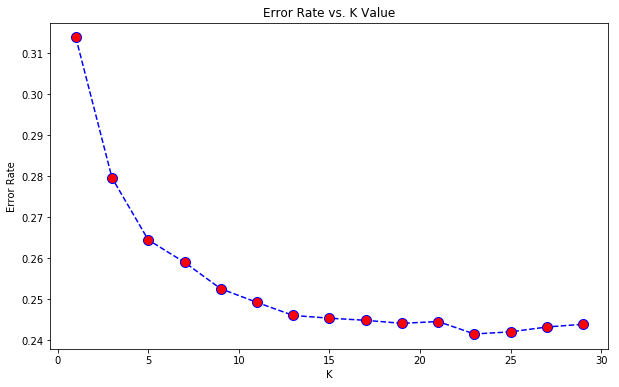

In [103]:
%%time
myList = list(range(0,3
optimal_k = find_optimal_k(X_train ,y_train,myList)

In [31]:
# here the best k is 23.

In [104]:
# performing K-NN with the best/optimal K.

knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [109]:
from sklearn.metrics import accuracy_score

print("Accuracy for KNN model with Bag of words is ",round(accuracy_score(y_test ,pred),3))


Accuracy for KNN model with Bag of words is  0.743


# KNN with tf-idf
 tf-idf vectors

In [36]:
# converting text to vectors by tf-idf method.
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()

final_tfidf_count = tf_idf_vec.fit_transform(final_string)



In [37]:
from gensim.models import Word2Vec


In [38]:
# standardizing
from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count )

In [39]:
# splitting the train and test datasets.

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = final_tfidf_np
y = final['Score']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(13519, 17934) (13519,)
(5794, 17934) (5794,)



The optimal number of neighbors is 3.
the misclassification error for each k value is :  [0.423 0.401 0.41  0.426 0.436 0.44  0.442 0.442 0.442 0.443 0.443 0.444
 0.444 0.444 0.445 0.445 0.445 0.445 0.445 0.445]


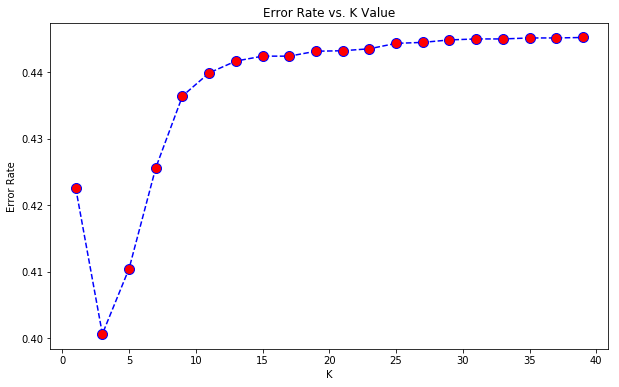

In [100]:
# finding best K which gives the least error.

myList = list(range(0,40))

optimal_k = find_optimal_k(X_train ,y_train,myList)


In [47]:
# KNN with tf-idf for optimal K

In [48]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [52]:
print("Accuracy for KNN model with tf-idf is ",round(accuracy_score(y_test ,pred),3))


Accuracy for KNN model with tf-idf is  0.606


# KNN with AvgW2V

In [101]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [40]:
import gensim
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    #str1 = b" ".join(filtered_sentence) #final string of cleaned words
            
    #final_string_for_tfidf.append(str1)
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [41]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)  


In [42]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [43]:
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = sent_vectors #final_w2v_count
y = final['Score']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)
#print (X_train.shape, y_train.shape)
#print (X_test.shape, y_test.shape)


The optimal number of neighbors is 39.
the misclassification error for each k value is :  [0.228 0.226 0.226 0.226 0.227 0.227]


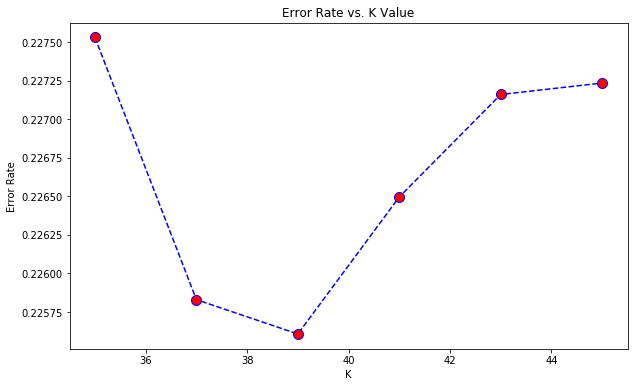

In [44]:
myList = list(range(35,47))

optimal_k = find_optimal_k(X_train ,y_train,myList)

In [45]:
#KNN with optimal K

knn = KNeighborsClassifier(n_neighbors=39)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [49]:
print("Accuracy for KNN model with Word2Vec is ",round(accuracy_score(y_test ,pred),3))


Accuracy for KNN model with Word2Vec is  0.782


# KNN with tf-ifd Weighted W2V

In [50]:
# td-idf vectors.

In [93]:
#from sklearn.feature_extraction.text import TfidfTransformer
#from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec_w = TfidfVectorizer()

final_tfidf_w = tf_idf_vec_w.fit_transform(final_string_for_tfidf)

In [94]:
tfidf_feat = tf_idf_vec_w.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1


In [95]:
# splitting the dataset

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier


X = tfidf_sent_vectors
y = final['Score']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)


In [96]:
# finding optimal K


The optimal number of neighbors is 23.
the misclassification error for each k value is :  [0.314 0.28  0.265 0.259 0.253 0.249 0.246 0.245 0.245 0.244 0.245 0.242
 0.242 0.243 0.244 0.247 0.245 0.244 0.245 0.245]
CPU times: user 3min 57s, sys: 559 ms, total: 3min 57s
Wall time: 3min 58s


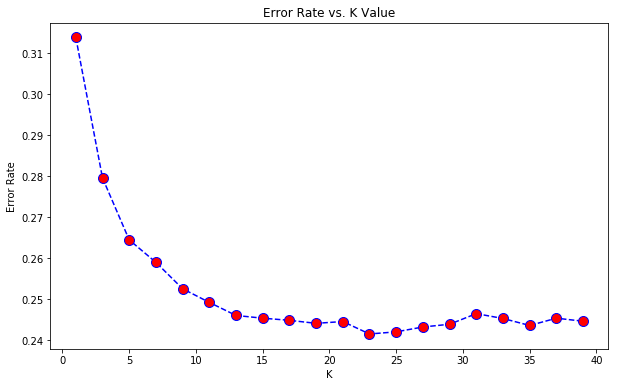

In [97]:
%%time
myList = list(range(0,40))

optimal_k = find_optimal_k(X_train ,y_train,myList)

In [98]:
# KNN with optimal K

knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

In [102]:
# printing accuracy

print("Accuracy for KNN model with tf-idf weighted Word2vec ",round(accuracy_score(y_test ,pred),3))

Accuracy for KNN model with tf-idf weighted Word2vec  0.743


Final Observation:

1) Out of these 4 methods of converting text to vector, the K-NN classifier prediction has acheived the best accuracy 
   of 78% on Avg W2V model which is greatest among all other conversions.

